In [10]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file
from yfetch import get_stock_history

In [16]:
# Define the ticker symbol
symbol = 'BRK-B'

# Get the historical prices for this ticker
history = get_stock_history(symbol, period='5y', interval='1wk')

Fetched history for BRK-B (262 rows)


In [17]:
gap = 5 / 500 * 100 # %

option_prices = {
    1: [510/3.85],
    2: [510/5.95],
    3: [510/7.72],
    4: [510/9.02],
    5: [510/10.65],
    8: [510/14.80],
    12: [510/20.20],
    17: [510/25.10],
    30: [510/35.70],
}
print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
# normalize values so longer expirations have lower leverage
option_leverage = {k: v for k, v in zip(sorted(option_leverage.keys()), sorted(option_leverage.values(), reverse=True))}

print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(symbol, option_leverage)

option leverages:
	 1w 132.5
	 2w 85.7
	 3w 66.1
	 4w 56.5
	 5w 47.9
	 8w 34.5
	12w 25.2
	17w 20.3
	30w 14.3
mean option leverage, break even:
	 1w 132.5  1.8%
	 2w 85.7  2.2%
	 3w 66.1  2.5%
	 4w 56.5  2.8%
	 5w 47.9  3.1%
	 8w 34.5  3.9%
	12w 25.2  5.0%
	17w 20.3  5.9%
	30w 14.3  8.0%
option gap: 1.00%


In [18]:
option_performance = []
for weeks in range(1, 53):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() * 52 / weeks
        median_profit = option_profits.median() * 52 / weeks
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append({
            'weeks': weeks,
            'mean_profit': mean_profit,
            'median_profit': median_profit,
            'positive_percent': positive_percent
        })
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

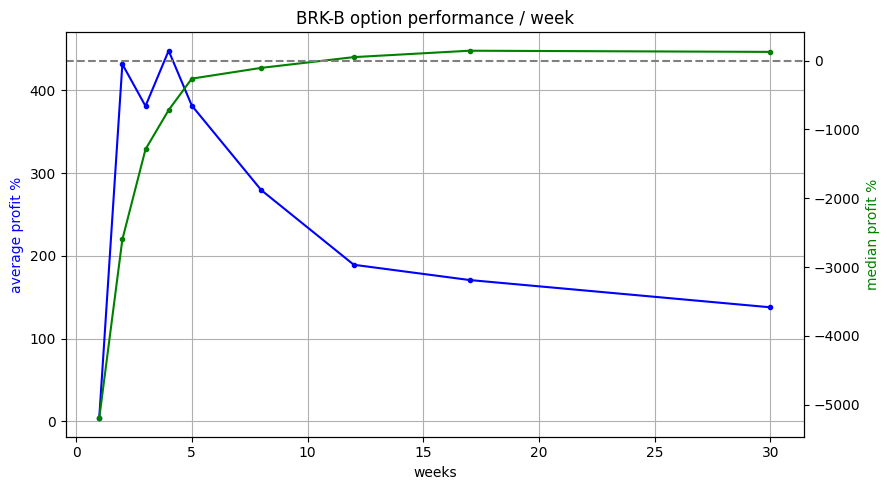

In [19]:
option_weeks = [p['weeks'] for p in option_performance]
option_mean_profit = [p['mean_profit'] for p in option_performance]
option_median_profit = [p['median_profit'] for p in option_performance]

fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()
ax1.plot(option_weeks, option_mean_profit, label='Average option profit', marker='.', color='b')
ax2.plot(option_weeks, option_median_profit, label='Median option profit', marker='.', color='g')
ax1.set_title(symbol + ' option performance / week')
ax1.set_xlabel('weeks')
ax1.set_ylabel('average profit %', color='b')
ax2.set_ylabel('median profit %', color='g')
ax2.axhline(y=0, color='grey', linestyle='--')
ax1.grid()
plt.tight_layout()
plt.show()

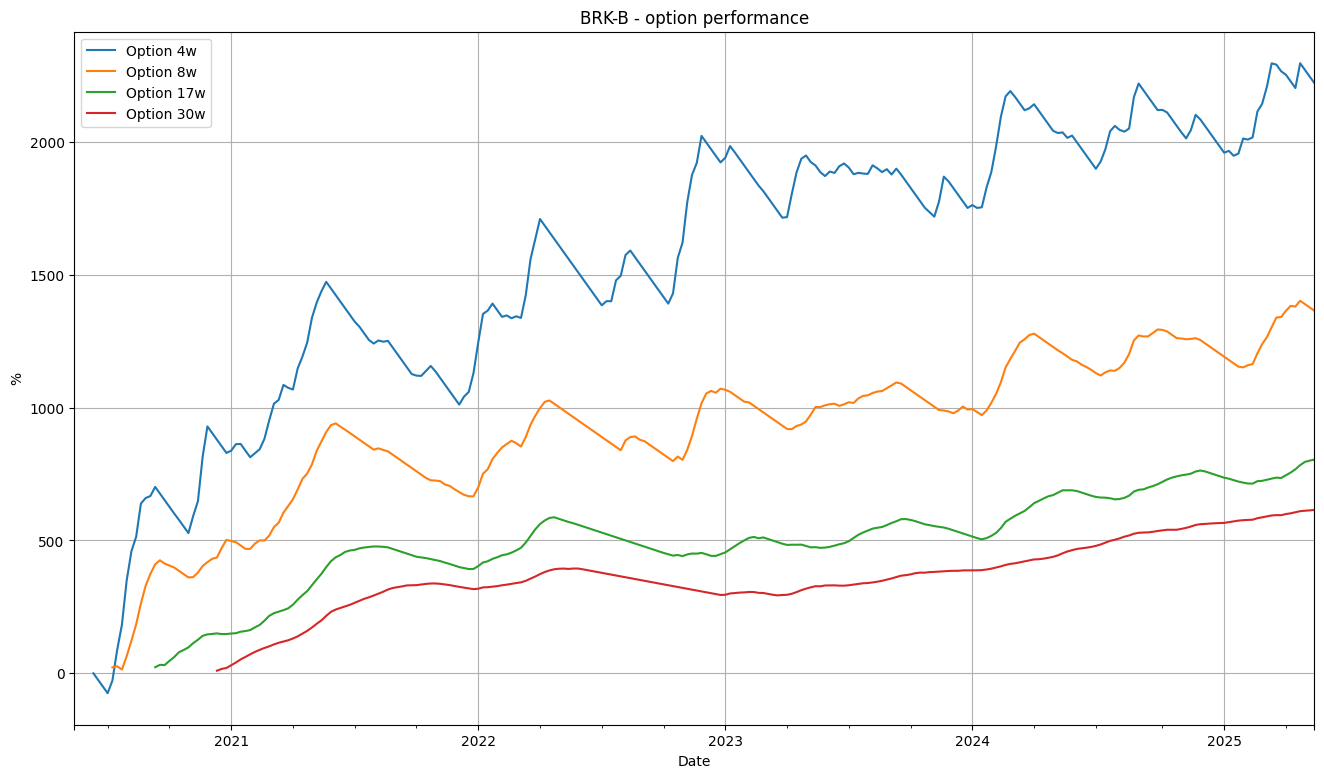

In [21]:
plt.figure(figsize=(16,9))

for w in [4,8,17,30]:
    (history[f'Option {w}w'].cumsum()/w).plot()

plt.legend()
plt.title(f'{symbol} - option performance')
plt.ylabel('%')
plt.grid()
plt.show()
